In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mne
import pickle
import seaborn as sns
from scipy.signal import stft
from scipy.fft import fft, fftfreq, ifft
import pandas as pd
import ast
from scipy import stats
import matplotlib.ticker as ticker
from statannotations.Annotator import Annotator
import matplotlib.animation as animation
from matplotlib import patches

plt.rcParams.update({'font.size': 11})

In [3]:
# get the rgb code of orange in matplotlib
orange = matplotlib.colors.to_rgb('orange')
# get the rgb code of blue in matplotlib
blue = matplotlib.colors.to_rgb('blue')

# any Elekta data path will work here as all we need is the 
# magnetometer channel locations to populate the mne.info object
dataset_path = os.path.join('/',
                            'well',
                            'woolrich',
                            'projects',
                            'cichy118_cont',
                            'raw_data',
                            'subj01',
                            'MEG2_subj01_sess01_tsss_mc-3.fif')
raw = mne.io.read_raw_fif(dataset_path, preload=True)
chn_type = 'mag'
raw = raw.pick(chn_type)

Opening raw data file /well/woolrich/projects/cichy118_cont/raw_data/subj01/MEG2_subj01_sess01_tsss_mc-3.fif...
    Range : 4930000 ... 5162999 =   4930.000 ...  5162.999 secs
Ready.


<ipython-input-3-0be2c4563481>:16: RuntimeWarning: This filename (/well/woolrich/projects/cichy118_cont/raw_data/subj01/MEG2_subj01_sess01_tsss_mc-3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(dataset_path, preload=True)


Reading 0 ... 232999  =      0.000 ...   232.999 secs...


# Figure 9
## Comparison of pairwise full-epoch models

In [3]:
def pairwise_comparison(df, ax):
    plot_params = {
        'ax':     ax,
        'aspect':  1,
        'cut':     0,
        'ci':      None,
        'scale':   'width',
        'data':    df,
        'x':       'model',
        'y':       'Validation accuracy',
        'legend':  None
    }

    sns.violinplot(**plot_params)

    ax.axhline(0.5, ls='--', color='black', label='chance')
    plt.xlabel('')

    # which pairs to computer stats on
    pairs = [('Pairwise LDA-NN', 'Multiclass LDA-NN')]

    # Add statistics annotations
    annotator = Annotator(ax, pairs, data=df, x='model', y='Validation accuracy')
    annotator.configure(test='Wilcoxon', verbose=True, line_offset_to_group=10).apply_and_annotate()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pairwise LDA-NN vs. Multiclass LDA-NN: Wilcoxon test (paired samples), P_val:6.104e-05 Stat=0.000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pairwise LDA-NN vs. Multiclass LDA-NN: Wilcoxon test (paired samples), P_val:6.104e-05 Stat=0.000e+00


/well/woolrich/users/yaq921/.conda/envs/main/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pairwise LDA-NN vs. Multiclass LDA-NN: Wilcoxon test (paired samples), P_val:3.390e-01 Stat=8.800e+01


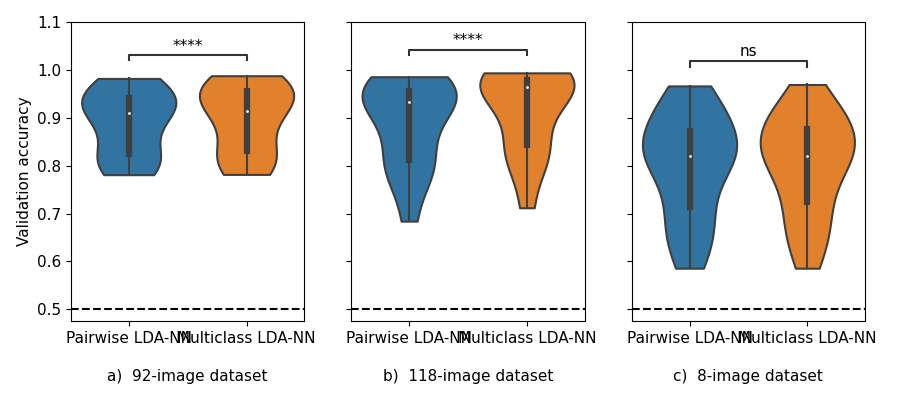

In [4]:
%matplotlib widget
fig, axes = plt.subplots(1, 3, figsize=(9,4), sharey=True)
axes = axes.flatten()
chance = [0.011, 0.008, 0.125]

# check these txt files to see how accuracies should be structured
# basically each row is a subject and the 2 columns are the direct pairwise
# and mutliclass-to-pairwise accuracies
# check the examples scripts for how to run these models and get the accuracies
# the three files correspond to the three datasets used in the paper
for i, file in enumerate(['pairwise92', 'pairwise118', 'pairwise_replay']):
    df = pd.read_csv(f'{file}.txt', sep="\t", header=0)
    df = df.stack().reset_index()
    df = df.rename(columns={'level_0': 'subject', 'level_1': 'model', 0: 'Validation accuracy'})

    pairwise_comparison(df, axes[i])

txt="\na)  92-image dataset"
axes[0].set_xlabel(txt, fontsize=11)

txt="\nb)  118-image dataset"
axes[1].set_xlabel(txt, fontsize=11)
axes[1].set_ylabel('')

txt="\nc)  8-image dataset"
axes[2].set_xlabel(txt, fontsize=11)
axes[2].set_ylabel('')

plt.tight_layout()

# Figure 7
## Spatiotemporal PFI

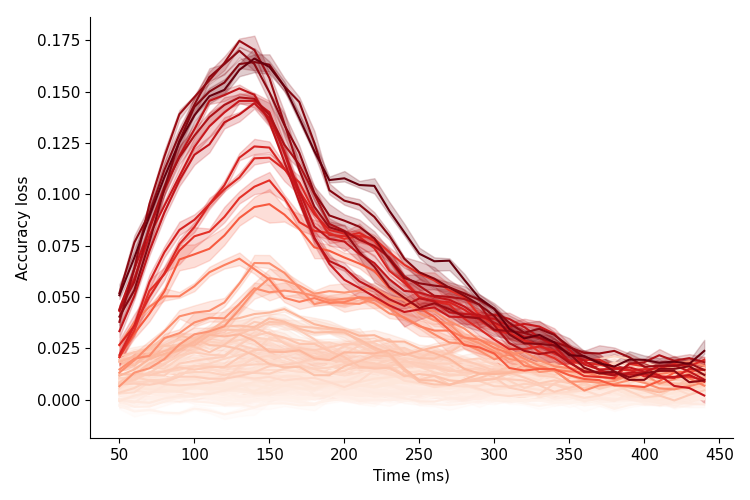

In [4]:
subs = 1  # number of subjects

# please see the examples script for how to run spatiotemporal PFI
# and obtain the following paths
paths = [os.path.join(
    '..', 'results_test', 'lda_nn', 'subj' + str(i),
    'spatiotemporalPFI', 'val_loss_PFIclosest4.npy') for i in range(subs)]

pfi_full = []
for path in paths:
    pfi = np.load(open(path, 'rb'))
    pfi = pfi[0, 0, 0] - pfi[:, :, 1:]

    pfi_full.append(pfi)

pfi_full = np.array(pfi_full)
pfi = np.mean(pfi_full, axis=0)

time_range = np.arange(50, 450, 10)

# times array
times = np.array([time_range for _ in range(pfi.shape[0])])
times = np.array([times.reshape(-1) for _ in range(pfi.shape[2])]).T
times = times.reshape(-1)

# channels array
pfi_pd = pfi.reshape(-1, pfi.shape[2])

# magnitudes for color hues
mags = np.abs(np.mean(pfi, axis=(0, 1)))
mags = np.array([mags/np.max(mags[:-1]) for _ in range(pfi_pd.shape[0])])
mags = mags.reshape(-1)

pfi_pd = pfi_pd.reshape(-1)

# put everything in a pd dataframe
pd_dict = {'Accuracy loss': pfi_pd, 'Time (ms)': times, 'relative magnitude': mags, 'channels': ['individual']*mags.shape[0]}
pfi_pd = pd.DataFrame(pd_dict)

%matplotlib widget
pfi_plot = sns.relplot(data=pfi_pd,
                       kind="line",
                       x="Time (ms)",
                       y="Accuracy loss",
                       hue='relative magnitude',
                       n_boot=10,
                       palette='Reds',
                       legend=None,
                       aspect=1.5)

plt.tight_layout()


In [5]:
ticks = list(range(len(time_range)))

# create evoked object for PFI
raw.resample(100)
evoked = mne.EvokedArray(np.mean(pfi, axis=0).T, raw.info, tmin=0.05)

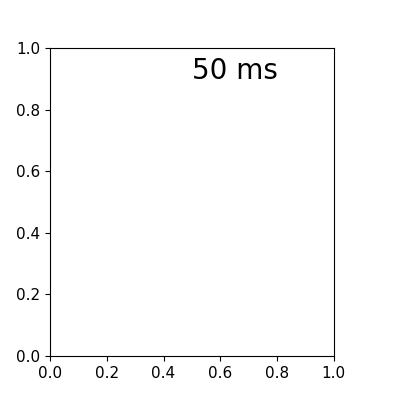

Initializing animation...
Initializing animation...
Initializing animation...


: 

In [8]:
%matplotlib widget
# create animation of temporal evolution of spatial PFI
times = np.arange(0.05, 0.44, 0.01)
fig, anim = evoked.animate_topomap(times=times,
                                   ch_type='mag',
                                   frame_rate=16,
                                   time_unit='ms',
                                   blit=False,
                                   show=False)

# adjust colorbar limits
anim._fig.axes[1].set_visible(False)
anim._fig.axes[0].text(0.5,0.9, str(time_range[0]) + ' ms', fontsize=20)

fig.set_size_inches(4, 4)

<ipython-input-6-3eb4cd023ea3>:3: FutureWarning: The "vmin" and "vmax" parameters are deprecated and will be removed in version 1.3. Use the "vlim" parameter instead.
  evoked.plot_topomap(times=times,


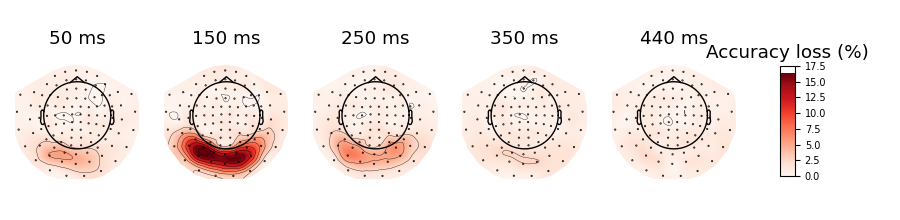

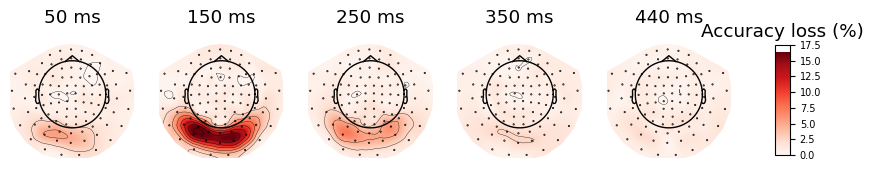

In [6]:
# plot spatial PFI at specific time points
times = [0.05, 0.15, 0.25, 0.35, 0.44]
evoked.plot_topomap(times=times,
                    ch_type='mag',
                    time_unit='ms',
                    scalings=100,
                    units='Accuracy loss (%)',
                    vmin=0)

# Figure 8b
## Temporo-Spectral PFI

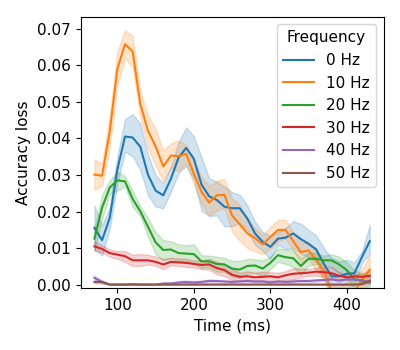

In [7]:
%matplotlib widget

hw = 1  # half window size
subs = 1  # number of subjects

# please see the examples script for how to run temporo-spectral PFI
# and obtain the following paths
paths = [os.path.join(
    '..', 'results_test', 'lda_nn', 'subj' + str(i),
    'temporospectralPFI', 'val_loss_PFIfreqs_ts2.npy') for i in range(subs)]

xf = fftfreq(50, 1/100)[:50//2]
xf = xf[hw:50//2-hw]
xf = [0, 10, 20, 30, 40, 50]  # frequency bins
xf = [str(x) + ' Hz' for x in xf]

pfi_full = []
for path in paths:
    pfi = np.load(open(path, 'rb'))

    pfi = pfi[0, 0, 0] - pfi[:, :, 2:-1]
    pfi_full.append(pfi)

pfi = np.mean(np.array(pfi_full), axis=(0))

time_range = np.arange(70,440,10).tolist()
values = []
times = []
freqs = []

for i in range(pfi.shape[0]):
    for f in range(pfi.shape[1]):
        values.extend(pfi[i, f])
        times.extend(time_range)
        freqs.extend([xf[f]] * len(time_range))

# create df for plotting
df = pd.DataFrame({'Accuracy loss': values, 'Time (ms)': times, 'Frequency': freqs})

# plot
fig, ax = plt.subplots(figsize=(4, 3.5))
sns.lineplot(data=df, x='Time (ms)', y='Accuracy loss', hue='Frequency', ax=ax)

plt.ylim(-0.001, None)

# add axis labels
plt.xlabel('Time (ms)')
plt.ylabel('Accuracy loss')

plt.tight_layout()

# Figure 8a
## Spectral PFI

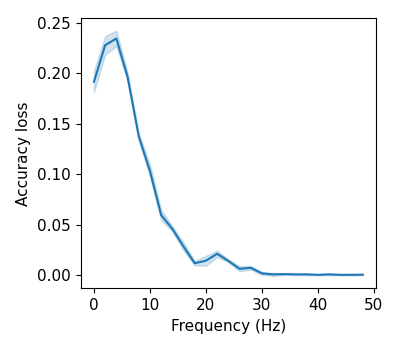

In [5]:
%matplotlib widget

hw = 0
subs = 1  # specify number of subjects

# please see the examples script for how to run spectral PFI
# and obtain the following paths
paths = [os.path.join(
    '..', 'results_test', 'lda_nn', f'subj{i}',
    'spectralPFI', 'val_loss_PFIfreqs0.npy') for i in range(subs)]

xf = fftfreq(50, 1/100)[:50//2]
xf = xf[hw:50//2-hw]
xf = np.round(xf)

pfi_full = []
for path in paths:
    pfi = np.load(open(path, 'rb'))
    pfi = pfi[0, 0] - pfi[:, 1:]

    pfi_full.append(pfi)

pfi = np.mean(np.array(pfi_full), axis=(0))


values = []
freqs = []

for i in range(pfi.shape[0]):
    values.extend(pfi[i])
    freqs.extend(xf)

# create df for plotting
df = pd.DataFrame({'Accuracy loss': values, 'Frequency (Hz)': freqs})
fig, ax = plt.subplots(figsize=(4, 3.5))
# plot
sns.lineplot(data=df, x='Frequency (Hz)', y='Accuracy loss', ax=ax)


# add axis labels
plt.xlabel('Frequency (Hz)')
plt.ylabel('Accuracy loss')

plt.tight_layout()

# Figure 13
## Spatio-Spectral PFI

(12750,)
(12750,)
(12750,)


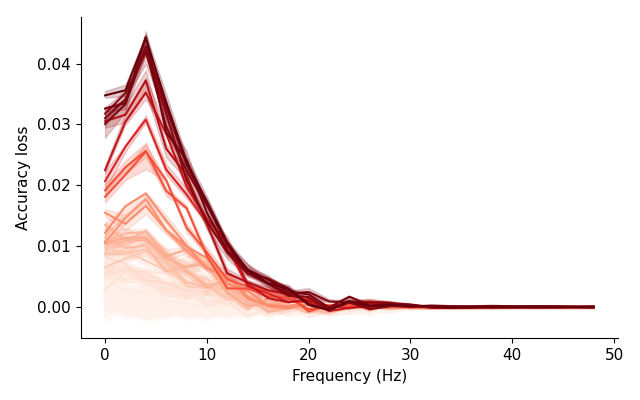

In [6]:
%matplotlib widget

hw = 0
subs = 15  # specify number of subjects

# please see the readme and examples script for how to run spatio-spectral PFI
# and obtain the following paths
paths = [os.path.join(
    '..', 'results', 'cichy_epoched',
    'lda25hz_noshuffle_conv80', 'subj' + str(i),
    'PFIfreq_ch', 'val_loss_PFIfreqs_ch0.npy') for i in range(subs)]

xf = fftfreq(50, 1/100)[:50//2]
xf = xf[hw:50//2-hw]
xf = np.round(xf)

pfi_full = []
for path in paths:
    pfi = np.load(open(path, 'rb'))
    #print(pfi.shape)
    pfi = pfi[0, 0, 0] - pfi[:, :, 1:]

    pfi_full.append(pfi)

pfi = np.mean(np.array(pfi_full), axis=(0))

xf = np.tile(xf, (pfi.shape[0], pfi.shape[2], 1))
xf = xf.transpose(0, 2, 1).reshape(-1)

pfi_pd = pfi.reshape(-1, pfi.shape[2])

mags = np.abs(np.mean(pfi, axis=(0, 1)))
mags_max = mags.max(axis=0)[np.newaxis]
mags = np.array([mags/mags_max for _ in range(pfi_pd.shape[0])])
mags = mags.reshape(-1)

pfi_pd = pfi.reshape(-1)

print(pfi_pd.shape)
print(xf.shape)
print(mags.shape)

# put everything in a pd dataframe
pd_dict = {'Output deviation': pfi_pd, 'Frequency (Hz)': xf, 'relative magnitude': mags}
pfi_pd = pd.DataFrame(pd_dict)

pfi_plot = sns.relplot(
    data=pfi_pd, kind="line", n_boot=10, height=4,
    x="Frequency (Hz)", y="Output deviation", hue='relative magnitude', legend=None, palette='Reds', aspect=1.6
)

# add axis labels
plt.xlabel('Frequency (Hz)')
plt.ylabel('Accuracy loss')

plt.tight_layout()

# Figure 6a
## Spatial PFI

In [8]:
def PFIch(pfipaths, ldapaths, inverse=False):
    lda_full = []
    pfi_full = []
    for pfipath, ldapath in zip(pfipaths, ldapaths):
        # load accuracies from ldapath
        lda = []
        with open(ldapath, 'r') as f:
            for line in f:
                lda.append(float(line.strip()))

        # load pfi from pfipath
        pfits = np.mean(np.load(open(pfipath, 'rb')), axis=0)
        if not inverse:
            pfits = pfits[0, 0] - pfits
        pfits = pfits[:, 1:]

        # crop lda to same length as pfits
        lda_full.append(np.array(lda))
        pfi_full.append(pfits)

    lda_full = np.mean(np.array(lda_full), axis=0)
    pfi_full = np.mean(np.array(pfi_full), axis=0)

    # plot
    vmin = 0.8 if inverse else 0
    evoked = mne.EvokedArray(pfi_full.T, raw.info, tmin=0)
    evoked.plot_topomap(times=[0],
                        ch_type='mag',
                        time_unit='ms',
                        scalings=1,
                        units='Accuracy loss (%)',
                        time_format='',
                        vlim=[vmin, None])

    evoked = mne.EvokedArray(lda_full.reshape(-1, 1), raw.info, tmin=0)
    evoked.plot_topomap(times=[0],
                        ch_type='mag',
                        time_unit='ms',
                        scalings=100,
                        units='Accuracy (%)',
                        time_format='',
                        vlim=[0.8, None])

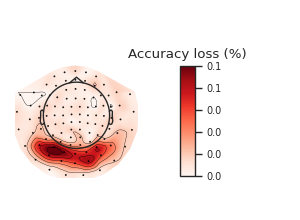

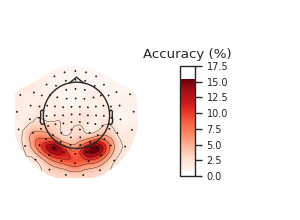

In [79]:
%matplotlib widget
subs = 1  # specify number of subjects

# please see the examples script for how to run spatial PFI
# and obtain the following paths
pfipath = [os.path.join(
    '..', 'results_test', 'lda_nn', f'subj{i}',
    'spatialPFI', 'val_loss_PFIclosest1.npy') for i in range(subs)]

# please see the examples script for how to run sliding channel LDA
# and obtain the following paths
ldapath = [os.path.join(
    '..', 'results_test', 'lda_nn', f'subj{i}',
    'sliding_channels', 'val_loss.txt') for i in range(subs)]
PFIch(pfipath, ldapath, inverse=False)

In [ ]:
%matplotlib widget

# alternatively, you can also run inverse spatial PFI
pfipath_inv = [os.path.join(
    '..', 'results', 'cichy_epoched', 
    'lda25hz_noshuffle_conv80', 'subj' + str(i),
    'PFIch_inverse', 'val_loss_PFIclosest1.npy') for i in range(subs)]

# inverse spatial PFI
PFIch(pfipath_inv, ldapath, inverse=True)

# Figure 5a
## Temporal PFI comparison with sliding window LDA

In [81]:
def PFIts(pfipaths, ldapaths, chance, shift=1, inverse=False, time_end=450, replay=False, df_fe=None):
    lda_full = []
    pfi_full = []
    for pfipath, ldapath in zip(pfipaths, ldapaths):
        # load accuracies from ldapath
        lda = []
        with open(ldapath, 'r') as f:
            for line in f:
                lda.append(float(line.strip()))

        # load pfi from pfipath
        pfits = np.load(open(pfipath, 'rb'))
        if not inverse:
            pfits = pfits[0, 0] - pfits
        pfits = pfits[:, 2:]

        # crop lda to same length as pfits
        lda = np.array(lda[shift:pfits.shape[1]+shift])
        lda_full.append(lda)
        pfi_full.append(pfits)

    lda_full = np.array(lda_full)

    if replay:
        p_values = []
        for i, t in enumerate(range(60, time_end, 10)):
            test1 = lda_full[:, i]
            test2 = df_fe['Validation accuracy'][df_fe['model']=='LDA-NN']
            
            p_values.append(stats.wilcoxon(test1, test2)[1] * 79)

        print(p_values)

    lda_full = np.mean(lda_full, axis=0)
    pfi_full = np.mean(np.array(pfi_full), axis=0)

    # plot pfi_full and lda_full with sns lineplot
    sns.set_context('paper')
    sns.set_style('white')
    
    # create a dataframe for the plot
    df = pd.DataFrame()
    df['time'] = np.arange(60, time_end, 10)
    df['lda'] = lda_full

    # flatten pfi_full and add to a different df
    # add a column for permutations which is axis 0 in pfi_full
    df_pfi = pd.DataFrame()
    df_pfi['time'] = np.tile(np.arange(60, time_end, 10), pfi_full.shape[0])
    df_pfi['pfi'] = pfi_full.reshape(-1)
    df_pfi['permutation'] = np.repeat(np.arange(pfi_full.shape[0]), pfi_full.shape[1])

    # plot lda_full and pfi_full
    fig, ax = plt.subplots(figsize=(3.6,3))
    sns.lineplot(data=df, x='time', y='lda', color=orange, ax=ax)
    #sns.lineplot(data=df_pfi, x='time', y='pfi', color=blue, ax=ax)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Validation accuracy', color=orange)

    # set legend
    ax.legend(['LDA-NN SW'], loc='upper right')

    # add a second y axis on the right
    ax2 = ax.twinx()
    sns.lineplot(data=df_pfi, x='time', y='pfi', color=blue, ax=ax2)
    ax2.set_ylabel('Validation accuracy loss', color=blue)
    ax2.legend(['LDA-NN FE PFI'], loc='upper right', bbox_to_anchor=(1.0, 0.9))

    # set lower and upper limits of y axis
    ax.set_ylim(chance-0.01)
    ax2.set_ylim(0.0)
    if chance == 0.011:
        ax2.set_ylim(0.03)

    ax.axhline(chance, ls='--', color='black', label='chance level')

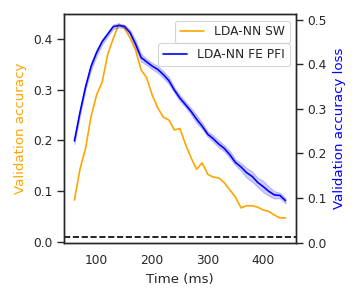

In [82]:
%matplotlib widget
subs = 1  # specify number of subjects
# please see the examples script for how to run temporal PFI
# and obtain the following paths
pfipath = [os.path.join(
    '..', 'results_test', 'lda_nn', f'subj{i}',
    'temporalPFI', 'val_loss_PFIts.npy') for i in range(subs)]

# this is the path to the standard sliding window LDA results
ldapath = [os.path.join(
    '..', 'results_test', 'lda_nn', f'subj{i}',
    'sliding_windows', 'val_loss.txt') for i in range(subs)]
PFIts(pfipath, ldapath, chance=0.008, shift=11)

plt.tight_layout()

In [ ]:
# alternatively, you can also run inverse temporal PFI
pfipath_inv = [os.path.join(
    '..', 'results', 'cichy_epoched', 
    'indiv_lda_25hz_conv80', 'subj' + str(i),
    'PFIts_inverse', 'val_loss_PFIts.npy') for i in range(15)]

# inverse temporal PFI
PFIts(pfipath_inv, ldapath, chance=0.008, inverse=True)

# Figure 2
## Comparing different sliding window models

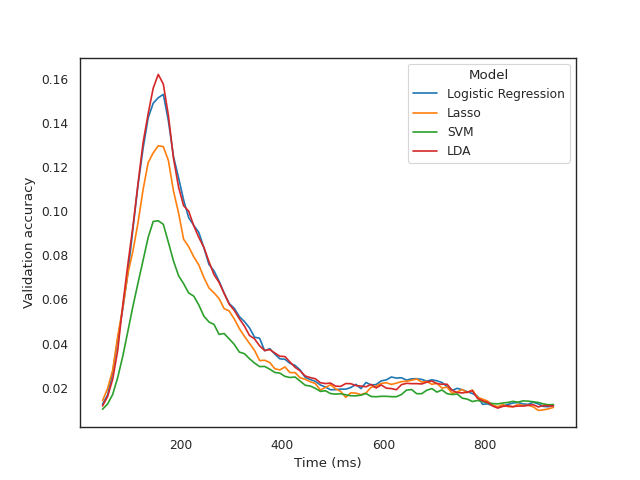

In [15]:
%matplotlib widget

# models.txt contains the validation accuracies for the
# sliding window LDA, Logistic regression, Lasso, and SVM
# please see the example scripts and the readme
# on how to run these models and obtain the accuracies
df = pd.read_csv('models.txt', sep="\t", header=0)
sliding_plot = sns.lineplot(data=df,
                            x="Time (ms)",
                            y="Validation accuracy",
                            hue='Model',
                            legend='full')

# Figure 10
# Comparing sliding window LDA-NN with different window sizes

In [16]:
def load_df(path, df):
    # Load sliding window data
    sliding_df = pd.read_csv(path, sep="\t", header=0)
    sliding_df = sliding_df.stack().reset_index()
    sliding_df = sliding_df.rename(columns={'level_0': 'subject', 'level_1': 'Time (ms)', 0: 'Validation accuracy'})

    model_type = []
    for i in range(len(sliding_df)):
        if '10ms' in sliding_df['Time (ms)'][i]:
            model_type.append('10ms')
            sliding_df['Time (ms)'][i] = sliding_df['Time (ms)'][i].replace(' (10ms)', '')
        elif '100ms' in sliding_df['Time (ms)'][i]:
            model_type.append('100ms')
            sliding_df['Time (ms)'][i] = sliding_df['Time (ms)'][i].replace(' (100ms)', '')
        elif '200ms' in sliding_df['Time (ms)'][i]:
            model_type.append('200ms')
            sliding_df['Time (ms)'][i] = sliding_df['Time (ms)'][i].replace(' (200ms)', '')
        elif '300ms' in sliding_df['Time (ms)'][i]:
            model_type.append('300ms')
            sliding_df['Time (ms)'][i] = sliding_df['Time (ms)'][i].replace(' (300ms)', '')
        elif '400ms' in sliding_df['Time (ms)'][i]:
            model_type.append('400ms')
            sliding_df['Time (ms)'][i] = sliding_df['Time (ms)'][i].replace(' (400ms)', '')

    sliding_df['model type'] = model_type

    # convert Time (ms) to int
    sliding_df['Time (ms)'] = sliding_df['Time (ms)'].astype(int)

    sub_df = df[df['model'] == 'LDA-NN']

    grouped_df = sliding_df.groupby(['Time (ms)', 'model type']).mean().reset_index()

    errors = []
    conf_int = []
    for t, m in zip(grouped_df['Time (ms)'], grouped_df['model type']):
        slice = np.array(sliding_df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == m)])
        err = slice - np.array(sub_df['Validation accuracy'])
        errors.append(err)

        conf_int.append(stats.t.interval(0.95, len(err)-1, loc=np.mean(err), scale=stats.sem(err)))
        # add back the mean
        conf_int[-1] = (conf_int[-1][0] + slice.mean(), conf_int[-1][1] + slice.mean())

    return sliding_df, conf_int

In [23]:
def plot_df(ax, sliding_df, df, conf_int, chance=0.008):
    p_200 = []
    p_300 = []
    p_400 = []

    tvals200 = list(range(95, 400, 10))
    tvals300 = list(range(145, 350, 10))
    tvals400 = list(range(195, 300, 10))

    all_comparisons = sum([len(tvals200), len(tvals300), len(tvals400)])
    for t in tvals200:
        test1 = sliding_df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == '200ms')]
        test2 = df['Validation accuracy'][df['model']=='LDA-NN']
        
        p_200.append(stats.wilcoxon(test1, test2)[1] * all_comparisons)

    for t in tvals300:
        test1 = sliding_df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == '300ms')]
        test2 = df['Validation accuracy'][df['model']=='LDA-NN']
        
        p_300.append(stats.wilcoxon(test1, test2)[1] * all_comparisons)

    for t in tvals400:
        test1 = sliding_df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == '400ms')]
        test2 = df['Validation accuracy'][df['model']=='LDA-NN']
        
        p_400.append(stats.wilcoxon(test1, test2)[1] * all_comparisons)

    # lines for full-epoch accuracy
    dots = np.array(tvals200)[np.array(p_200)<0.05]
    avg = np.average(df['Validation accuracy'][df['model']=='LDA-NN'])
    ax.plot(dots, [0.7]*len(dots), 'go', markersize=2, label='LDA-NN FE <> LDA-NN 200ms (p<0.05)')

    dots = np.array(tvals300)[np.array(p_300)<0.05]
    avg = np.average(df['Validation accuracy'][df['model']=='LDA-NN'])
    ax.plot(dots, [0.72]*len(dots), 'ro', markersize=2, label='LDA-NN FE <> LDA-NN 300ms (p<0.05)')

    dots = np.array(tvals400)[np.array(p_400)<0.05]
    avg = np.average(df['Validation accuracy'][df['model']=='LDA-NN'])
    ax.plot(dots, [0.74]*len(dots), 'o', color='purple', markersize=2, label='LDA-NN FE <> LDA-NN 400ms (p<0.05)')

    # modify sliding_df so that the subject column is averaged out
    sliding_df = sliding_df.groupby(['Time (ms)', 'model type']).mean().reset_index()
    sliding_df['conf_int'] = conf_int

    # Plot sliding window data, with legend inside the plot and sparse x ticks
    sliding_plot = sns.lineplot(data=sliding_df,
                                x="Time (ms)",
                                y="Validation accuracy",
                                hue='model type',
                                legend='full',
                                ax=ax)

    ax.set_xlim(0, None)

    ax.axhline(avg, ls='--', color='grey', label='full-epoch accuracy')

    ax.axhline(chance, ls='--', color='black', label='chance level')

In [21]:
# load the full-epoch data for each subject
# see examples/args_lda_nn_fe_multiclass.py for how to get this
df118 = pd.read_csv('cichy118_epoch.txt', sep="\t", header=0)
df118 = df118.stack().reset_index()
df118 = df118.rename(columns={'level_0': 'subject', 'level_1': 'model', 0: 'Validation accuracy'})

<ipython-input-16-7a702d3d7f6a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliding_df['Time (ms)'][i] = sliding_df['Time (ms)'][i].replace(' (10ms)', '')
<ipython-input-16-7a702d3d7f6a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliding_df['Time (ms)'][i] = sliding_df['Time (ms)'][i].replace(' (100ms)', '')
<ipython-input-16-7a702d3d7f6a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliding_df['Time (ms)'][i] = slidi

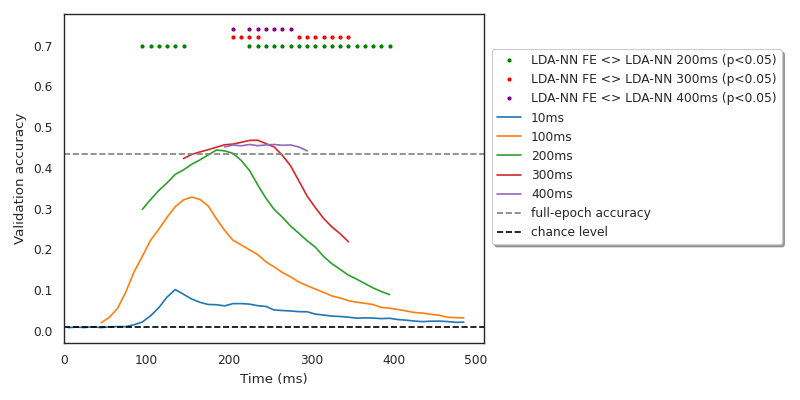

In [24]:
# sliding_windows.txt contains the validation accuracies for the
# sliding window LDA with different window sizes
# please see the example scripts and the readme
# on how to run these models and obtain the accuracies
cichy118_df, conf_int = load_df('sliding_windows.txt', df118)
%matplotlib widget
fig, axes = plt.subplots(figsize=(8, 4))


plot_df(axes, cichy118_df, df118, conf_int, 0.008)

handles, labels = axes.get_legend_handles_labels()

# remove legend of axes
axes.legend_.remove()
axes.legend(handles,
           labels,
           loc=(-1, -1),
           bbox_to_anchor=(1.02, 0.3),
           fancybox=True,
           shadow=True)

plt.tight_layout()

In [25]:
sub_df = df118[df118['model'] == 'LDA-NN']
err = np.array(cichy118_df['Validation accuracy'][(cichy118_df['Time (ms)'] == 145) & (cichy118_df['model type'] == '100ms')]) - np.array(sub_df['Validation accuracy'])
stats.t.interval(0.95, len(err)-1, loc=np.mean(err), scale=stats.sem(err))

(-0.1409116056517083, -0.08353283888162504)

# Figure 14
## Comparison of sliding window LDA-NN with training on wavelet features

In [26]:
def load_df(paths, names):
    # load accuracies from ldapath
    times = []
    subjects = []
    values = []
    model = []
    time_range = list(range(45, 940, 10))

    for path, name in zip(paths, names):
        lda = []
        with open(path, 'r') as f:
            for line in f:
                lda.append(line.split(';'))
                lda[-1] = [float(x) for x in lda[-1]]

        lda = np.array(lda)

        # create df from lda (subjects x time)
        for i in range(lda.shape[0]):
            times.extend(time_range)
            subjects.extend([i] * lda.shape[1])
            values.extend(lda[i])
            model.extend([name] * lda.shape[1])

    df = pd.DataFrame()

    df['Time (ms)'] = times
    df['subject'] = subjects
    df['Validation accuracy'] = values
    df['model type'] = model

    return df

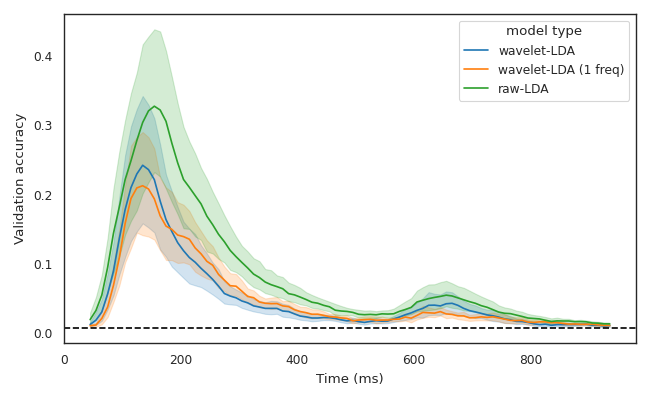

In [27]:
%matplotlib widget
# see the readme on how to train LDA models with wavelet features
paths = ['../results/cichy_epoched/indiv25hz_lda_conv+wavelet/all_losses.txt',
         '../results/cichy_epoched/indiv25hz_lda_conv+wavelet_freq/all_losses.txt',
         '../results/cichy_epoched/indiv_lda_25hz_conv80/all_losses.txt']
names = ['wavelet-LDA', 'wavelet-LDA (1 freq)', 'raw-LDA']

df = load_df(paths, names)

fig, ax = plt.subplots(1, 1, figsize=(6.5, 4))

# Plot sliding window data, with legend inside the plot and sparse x ticks
sliding_plot = sns.lineplot(data=df,
                            x="Time (ms)",
                            y="Validation accuracy",
                            hue='model type',
                            legend='full',
                            n_boot=1000,
                            ax=ax)

ax.set_xlim(0, None)
ax.axhline(0.008, ls='--', color='black', label='chance level')
plt.tight_layout()

# Figure 3
## Sliding window comparison between LDA-NN and LDA-PCA

In [57]:
def load_df_replay(ldapaths):
    lda_full = []
    for ldapath in ldapaths:
        # load accuracies from ldapath
        lda = []
        with open(ldapath, 'r') as f:
            for line in f:
                lda.append(float(line.strip()))

        # crop lda to same length as pfits
        lda_full.append(np.array(lda))

    return  np.array(lda_full)


def merge_replay(nn, pca):
    time_range = list(range(-55, 950, 10))

    times = []
    subjects = []
    values = []
    model = []
    for i in range(nn.shape[0]):
        times.extend(time_range)
        subjects.extend([i] * nn.shape[1])
        values.extend(nn[i])
        model.extend(['LDA-NN SW'] * nn.shape[1])

    for i in range(pca.shape[0]):
        times.extend(time_range)
        subjects.extend([i] * pca.shape[1])
        values.extend(pca[i])
        model.extend(['LDA-PCA SW'] * pca.shape[1])

    # create a dataframe for the plot
    df = pd.DataFrame()

    df['Time (ms)'] = times
    df['subject'] = subjects
    df['Validation accuracy'] = values
    df['model type'] = model

    return df

In [29]:
def load_df(path):
    # Load sliding window data
    sliding_df = pd.read_csv(path, sep="\t", header=0)
    sliding_df = sliding_df.stack().reset_index()
    sliding_df = sliding_df.rename(columns={'level_0': 'subject', 'level_1': 'Time (ms)', 0: 'Validation accuracy'})

    model_type = []
    for i in range(len(sliding_df)):
        if 'pca' in sliding_df['Time (ms)'][i]:
            model_type.append('LDA-PCA SW')
            sliding_df['Time (ms)'][i] = sliding_df['Time (ms)'][i].replace(' (pca)', '')
        else:
            model_type.append('LDA-NN SW')
    sliding_df['model type'] = model_type

    # convert Time (ms) to int
    sliding_df['Time (ms)'] = sliding_df['Time (ms)'].astype(int)

    return sliding_df

In [55]:
def plot_df(ax, sliding_df, df, chance, end=940):
    p_values = []
    p_conv = []
    p_pca = []
    start_ts = -55
    leng = int(end/10)
    for t in range(start_ts, end, 10):
        test1 = sliding_df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == 'LDA-PCA SW')]
        test2 = sliding_df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == 'LDA-NN SW')]
        
        p_values.append(stats.wilcoxon(test1, test2)[1] * leng)

        test1 = sliding_df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == 'LDA-NN SW')]
        test2 = df['Validation accuracy'][df['model']=='LDA-NN']
        
        p_conv.append(stats.wilcoxon(test1, test2)[1] * leng)

        test1 = sliding_df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == 'LDA-PCA SW')]
        test2 = df['Validation accuracy'][df['model']=='LDA-PCA']
        
        p_pca.append(stats.wilcoxon(test1, test2)[1] * leng)

    
    dots = np.array(range(start_ts, end, 10))[np.array(p_values)<0.05]
    ax.plot(dots, [0.5]*len(dots), 'ro', markersize=2, label='LDA-NN SW > LDA-PCA SW (p<0.05)')

    # lines for full-epoch accuracy
    dots = np.array(range(start_ts, end, 10))[np.array(p_conv)<0.05]
    avg = np.average(df['Validation accuracy'][df['model']=='LDA-NN'])
    #ax.plot(dots, [avg]*len(dots), 'bo', markersize=2, label='LDA-NN FE > LDA-NN SW (p<0.05)')
    ax.axhline(avg, ls='--', color='orange', label='LDA-NN FE')

    dots = np.array(range(start_ts, end, 10))[np.array(p_pca)<0.05]
    avg = np.average(df['Validation accuracy'][df['model']=='LDA-PCA'])
    #ax.plot(dots, [avg]*len(dots), 'o', color='orange', markersize=2, label='LDA-PCA FE > LDA-PCA SW (p<0.05)')
    ax.axhline(avg, ls='--', color='blue', label='LDA-PCA FE')

    # Plot sliding window data, with legend inside the plot and sparse x ticks
    sliding_plot = sns.lineplot(data=sliding_df,
                                x="Time (ms)",
                                y="Validation accuracy",
                                hue='model type',
                                hue_order=['LDA-PCA SW', 'LDA-NN SW'],
                                legend='full',
                                n_boot=1000,
                                ax=ax)

    ax.set_xlim(0, None)
    ax.set_ylim(-0.01, None)

    ax.axhline(chance, ls='--', color='black', label='chance level')

In [47]:
def load_fullepoch(ldapaths):
    lda_full = []
    for ldapath in ldapaths:
        # load accuracies from ldapath
        with open(ldapath, 'r') as f:
            for line in f:
                lda_full.append(float(line.strip()))

    return  np.array(lda_full)


def merge_fullepoch(nn, pca):
    subjects = list(range(nn.shape[0]))
    values = list(nn)
    model = ['LDA-NN'] * nn.shape[0]
    
    subjects.extend(list(range(pca.shape[0])))
    values.extend(list(pca))
    model.extend(['LDA-PCA'] * pca.shape[0])

    # create a dataframe for the plot
    df = pd.DataFrame()

    df['subject'] = subjects
    df['Validation accuracy'] = values
    df['model'] = model

    return df

In [58]:
subs = 1  # number of subjects

# see example scripts on how to run LDA-NN and LDA-PCA
ldapath = [os.path.join(
    '..', 'results_test', 'lda_nn', f'subj{i}',
    'sliding_windows', 'val_loss.txt') for i in range(subs)]
lda_nn = load_df_replay(ldapath)

ldapath = [os.path.join(
    '..', 'results_test', 'lda_pca', f'subj{i}',
    'sliding_windows', 'val_loss.txt') for i in range(subs)]
lda_pca = load_df_replay(ldapath)

# merge the two dataframes
df = merge_replay(lda_nn, lda_pca)

In [48]:
# load full-epoch data for LDA-NN and LDA-PCA
# see example scripts on how to run these models
ldapath = [os.path.join(
    '..', 'results_test', 'lda_nn', f'subj{i}',
    'val_loss.txt') for i in range(subs)]
lda_nn = load_fullepoch(ldapath)

ldapath = [os.path.join(
    '..', 'results_test', 'lda_pca', f'subj{i}',
    'val_loss.txt') for i in range(subs)]
lda_pca = load_fullepoch(ldapath)

# merge the two dataframes
df_fe = merge_fullepoch(lda_nn, lda_pca)

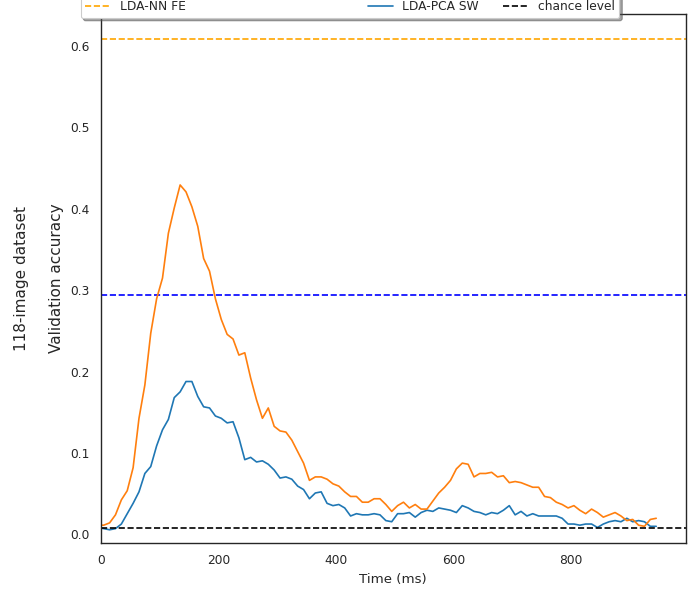

In [59]:
%matplotlib widget
fig, axes = plt.subplots(1, 1, figsize=(7, 6), sharex=True)

plot_df(axes, df, df_fe, 0.008)

handles, labels = axes.get_legend_handles_labels()

# remove legend of axes
axes.legend_.remove()
fig.legend(handles,
           labels,
           loc='upper center',
           bbox_to_anchor=(0.5, 1.05),
           fancybox=True,
           shadow=True,
           ncol=3)

txt="118-image dataset\n\nValidation accuracy"
axes.set_ylabel(txt, fontsize=11)

plt.tight_layout()

# Figure 4
## Full-epoch comparison between LDA-NN, LDA-PCA, and neural network

In [60]:
def plot_fullepoch(df, ax, chance):
    # Putting the parameters in a dictionary avoids code duplication
    # since we use the same for `sns.boxplot` and `Annotator` calls
    plot_params = {
        'ax':      ax,
        'aspect':  1,
        'cut':     0,
        'ci':      None,
        'scale':   'width',
        'data':    df,
        'x':       'model',
        'y':       'Validation accuracy',
        'legend':  None
    }

    sns.violinplot(**plot_params)

    ax.axhline(chance, ls='--', color='black', label='chance')

    # which pairs to computer stats on
    pairs = [('LDA-PCA', 'LDA-NN'), ('LDA-NN', 'Neural Network')]

    # Add statistics annotations
    annotator = Annotator(ax, pairs, data=df, x='model', y='Validation accuracy')
    annotator.configure(test='Wilcoxon', verbose=True, line_offset_to_group=10).apply_and_annotate()

In [70]:
def load_fullepoch(ldapaths):
    lda_full = []
    for ldapath in ldapaths:
        # load accuracies from ldapath
        with open(ldapath, 'r') as f:
            for line in f:
                lda_full.append(float(line.strip()))

    return  np.array(lda_full)

def load_nn(paths):
    accs = []
    for path in paths:
        # load accuracies from ldapath
        with open(path, 'r') as f:
            for line in f:
                d = ast.literal_eval(line)
                d = d['valloss/valcriterion/Validation accuracy: ']
                accs.append(float(d))

    return np.array(accs)


def merge_fullepoch(ldann, pca, nn):
    subjects = list(range(ldann.shape[0]))
    values = list(ldann)
    model = ['LDA-NN'] * ldann.shape[0]
    
    subjects.extend(list(range(pca.shape[0])))
    values.extend(list(pca))
    model.extend(['LDA-PCA'] * pca.shape[0])

    subjects.extend(list(range(nn.shape[0])))
    values.extend(list(nn))
    model.extend(['Neural Network'] * nn.shape[0])

    # create a dataframe for the plot
    df = pd.DataFrame()

    df['subject'] = subjects
    df['Validation accuracy'] = values
    df['model'] = model

    return df

In [71]:
# load full-epoch data for LDA-NN, LDA-PCA, and the Neural Network
# see example scripts on how to run these models
subs = 1  # number of subjects
ldapath = [os.path.join(
    '..', 'results_test', 'lda_nn', f'subj{i}',
    'val_loss.txt') for i in range(subs)]
lda_nn = load_fullepoch(ldapath)

ldapath = [os.path.join(
    '..', 'results_test', 'lda_pca', f'subj{i}',
    'val_loss.txt') for i in range(subs)]
lda_pca = load_fullepoch(ldapath)

ldapath = [os.path.join(
    '..', 'results_test', 'neural_network', f'subj{i}',
    'val_loss.txt') for i in range(subs)]
nn = load_nn(ldapath)

# merge the three dataframes
df_fe = merge_fullepoch(lda_nn, lda_pca, nn)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LDA-NN vs. LDA-PCA: Wilcoxon test (paired samples), P_val:1.000e+00 Stat=0.000e+00
LDA-NN vs. Neural Network: Wilcoxon test (paired samples), P_val:1.000e+00 Stat=0.000e+00


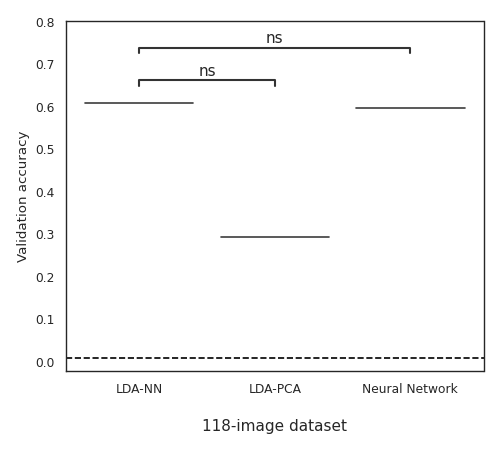

In [72]:
%matplotlib widget

# note that plotting with 1 subject will show a single line
# instead of the violin plot
fig, axes = plt.subplots(1, 1, figsize=(5, 4.5), sharey=True)
plot_fullepoch(df_fe, axes, 0.008)

txt="\n118-image dataset"
axes.set_xlabel(txt, fontsize=11)

plt.tight_layout()